In [1]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr

# Ilan
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
#from icecream import ic
#import nc_time_axis
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [5]:
catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'
combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print(list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [73]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 7
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
# ds = combo_cat.xsh24_native(zoom=zoom_select).to_dask()
# ds = ds.pipe(egh.attach_coords)

# # we downloaded output from DOE's SCREAM model to stellar
# # conceivably, we could add to our local collection of models during the week
# # or augment the catalog with observational datasets
# ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
# ds_scream = ds_scream.pipe(egh.attach_coords)

/home/ee5357/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


#### Variables (coarse model)
CPRATEsfc_coarse: coarsened 2D 3 hr surface convective precipitation rate 
HPBLsfc_coarse: coarsened 2D 3 hr surface planetary boundary layer height [m] 
LHTFLsfc_coarse: coarsened 2D 3 hr surface latent heat flux [W/m**2]
pr_coarse: coarsened 2D 3 hr bucket surface precipitation rate
meantbclrisccp_coarse: coarsened 2D 3 hr ISCCP clear-sky 10.5 micron brightness temperature / toa_brightness_temperature_assuming_clear_sky 
meantbisccp_coarse: coarsened 2D 3 hr ISCCP all-sky 10.5 micron brightness temperature / toa_brightness_temperature 

#### Variables (native model)
pr: native-res 2D 3 hr bucket surface precipitation rate
40dBz_height: native-res 2D 3 hr Height of 40 dBz reflectivity 
CAPE_max: native-res 2D 3 hr Convective available potential energy (surface-based)
soilm: native-res 2D 24 hr total column soil moisture content [kg/m**2]
uh25_max: native-res 2D 3 hr 2-5 km Updraft Helicity 
uh25_min: native-res 2D 3 hr 2-5 km Updraft Helicity
wmaxup_max: native-res 2D 3 hr column-maximum updraft (below 100 mb)
meantbisccp: native-res 2D 3 hr ISCCP all-sky 10.5 micron brightness temperature / toa_brightness_temperature

In [69]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()

    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    
def usmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=-90)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_extent([-130, -70, 20, 50])
    
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)
    
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    #ax.coastlines(linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)

[########################################] | 100% Completed | 517.19 ms


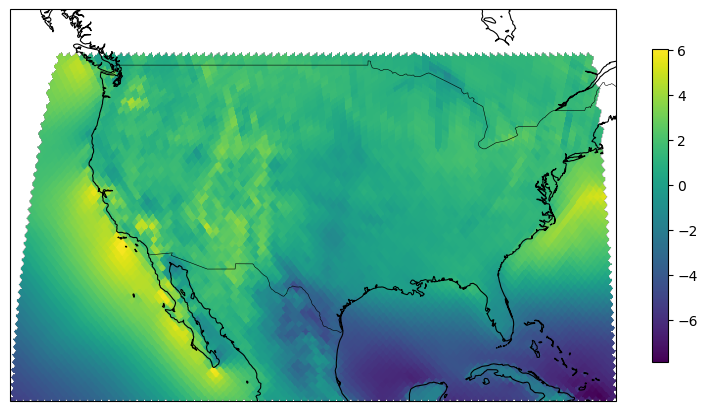

In [75]:
# def preprocess(ds):
#     res = ds \
#         .assign(wind=lambda x: np.sqrt(x['ua']**2 + x['va']**2)) \
#         .assign(height=lambda x: x['zg']) # geopotential
#     #.assign(swind=lambda x: np.sqrt(x['uas']**2 + x['vas']**2)) \
#     return res

# Select the GPPLJ regions
us = ((ds.lat <= 50) & (ds.lat >= 20) & (ds.lon >= -130+360) & (ds.lon <= -70+360))
ds_us = ds.isel(cell=us)
#print(ds_us.uas.coords)
#print(ds_us.uas.sel(time='2020-06-06 00:00:00'))
usmap(ds_us.uas.sel(time=slice('2020-06-01', '2020-07-01')).mean('time'))

In [89]:
llj_count = xr.open_dataset('/scratch/cimes/iv4111/hk25-data/llj_CONUS.h5', chunks={})
#print(llj_count.mask.sel(time='2020-06-06 00:00:00').squeeze())
#print(llj_count.mask.isel(time=0))

#### MCS ID metrics
Heavy rain rate thresh: 5 mm/hr
Min rain rate thresh: 0.5 mm/hr
cloudtb_core:  225.0  # [K]
cloudtb_cold:  241.0  # [K]
cloudtb_warm:  261.0  # [K]
cloudtb_cloud:  261.0  # [K]
absolutetb_threshs: [160, 330]

[########################################] | 100% Completed | 122.74 ms
[########################################] | 100% Completed | 104.13 ms
[########################################] | 100% Completed | 104.14 ms


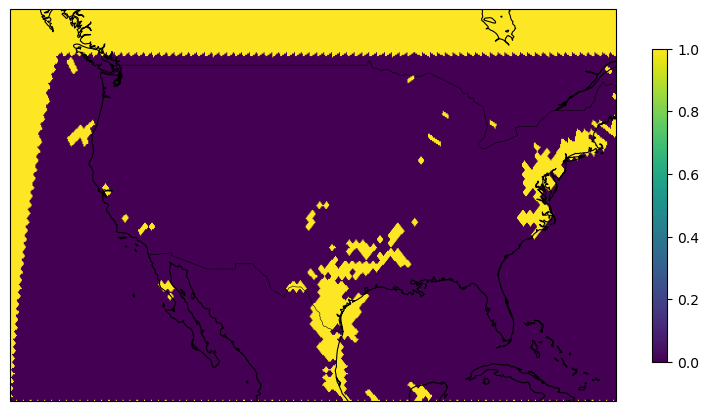

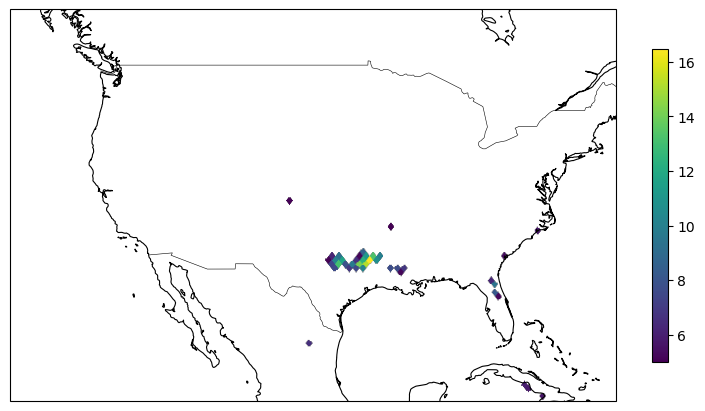

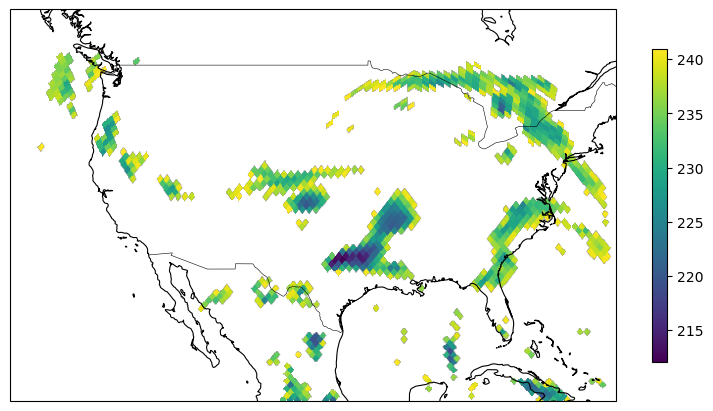

In [114]:
t = '2020-06-06 00:00:00'
#usmap(llj_count.mask.sel(time=t).squeeze())

#print(ds_us)
pconv = 3600  # 1 mm == 1 kg/m2, 3600 s / hr
us_precip = ds_us.pr * pconv  # kg / m2 / s --> mm/hr
#print(us_precip)
us_tb = (ds_us.rlut / 5.6693e-8) ** 0.25

# spatial filtering, add gaussian check cam MJO code
# us_precip.rolling(dim={'time': 3}, min_periods=3)
# usmap(us_precip.isel(time=100))

llj = llj_count.mask.sel(time=t).squeeze()
# TODO: some dependence on LLJ max speed? like
pre = us_precip.sel(time=t).squeeze()
tb = us_tb.sel(time=t).squeeze()

usmap(llj)
# usmap(pre)
# usmap(tb)
# # ds_us

prep = pre.where(pre > 5.0)
usmap(prep)

filter_tb = tb.where(tb < 241.0)
usmap(filter_tb)